In [1]:
import numpy as np
from PIL import Image, ImageTk
import Tkinter
from timeit import default_timer as timer
import time
from images2gif import writeGif
import scipy.misc
import shutil
import subprocess
from PIL import Image
from IPython import display
from IPython.display import HTML
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

import os, sys
sys.path.insert(0, os.path.dirname(os.path.abspath('..')))
from rpca.pcp import pcp
from rpca.mwrpca import mwrpca
from rpca.stoc_rpca  import stoc_rpca
from rpca.omwrpca  import omwrpca
from rpca.omwrpca_cp  import omwrpca_cp

### Define utility functions

In [2]:
def bitmap_to_mat(bitmap_seq):
    matrix = []

    for bitmap_file in bitmap_seq:
        im = Image.open(bitmap_file).convert('L') # convert to grayscale
        pixels = list(im.getdata())
        matrix.append(pixels)

    return np.array(matrix)

In [3]:
def bitmap_to_mat_jump_window(bitmap_seq, w, h):
    """
    w: width of pic
    h: height of pic
    """
    matrix = []
    k = 0
    for bitmap_file in bitmap_seq:
        k += 1
        im = Image.open(bitmap_file).convert('L') # convert to grayscale
        if k <= 1000 or k > 2000:
            im = im.crop((0, 0, w/2, h))
        else:
            im = im.crop((w/2, 0, w, h))
        pixels = list(im.getdata())
        matrix.append(pixels)
     
    return np.array(matrix)

In [4]:
def bitmap_to_mat_jump_move_window(bitmap_seq, w, h, njumps=10):
    """
    w: width of pic
    h: height of pic
    njumps: number of frames with one move
    """
    matrix = []
    k = 0
    index = 0
    direct = 1
    for bitmap_file in bitmap_seq:
        k += 1
        if k == njumps*(w/2) + 1:
            # jump from the right side to left side
            index = 0
            direct = 1
        else:
            # move 1 pixel every njumps obs.
            if k % njumps ==0:
                index += direct
            if index == -1:
                index = 1
                direct *= -1
            elif index == w/2:
                index = w/2 - 2
                direct *= -1
        im = Image.open(bitmap_file).convert('L') # convert to grayscale
        im = im.crop((index, 0, index + w/2, h))
        pixels = list(im.getdata())
        matrix.append(pixels)
     
    return np.array(matrix)

In [5]:
def animate(matrices, w, h):
    mats = [np.load(x) for x in matrices]
    tk_win = Tkinter.Toplevel()
    canvas = Tkinter.Canvas(tk_win, width=7*w, height=7*h)
    canvas.pack()
    tk_ims = [None for _ in mats]
    for i, row in enumerate(mats[0]):
        ims = [Image.new('L', (w, h)) for _ in mats]
        for j, im in enumerate(ims):
            im.putdata(map(float, list(mats[j][i])))
            tk_ims[j] = ImageTk.PhotoImage(im)
            canvas.create_image((j * w) + 200, h, image = tk_ims[j])
            canvas.update()
#            time.sleep(0.001)
    

In [6]:
def writeGifMatric(file_name, mats, duration, w, h):
    ims = [Image.new('L', (w, h)) for _ in range(mats.shape[0])]
    for j, im in enumerate(ims):
        im.putdata(map(float, mats[j]))
    writeGif(file_name, ims, duration=duration)

In [7]:
def writeMatricPng(folder, filename, mats, w, h):
    n, m = mats.shape
    assert (m == w*h), "incorrect w or h"
    for i in range(n):
        target = mats[i,:].reshape((w,h), order='F').transpose()
        scipy.misc.imsave(folder + filename + str(1000+i) + '.png', target)        
    

In [8]:
def display_gif(fn):
    return display.HTML('<img src="{}">'.format(fn))

In [9]:
def display_gifs(fns):
    imagesList=''.join( ["<img style='width: 300px; margin: 0px; float: left; border: 1px solid black;' src='%s' />" % str(s) 
                 for s in fns])
    return display.HTML(imagesList)

### Resize the image (40X32)

### Read in video data and save as PNGs

#### lobby video (160X128)

In [10]:
bmp_seq = map(lambda s: os.path.join("./lobby/", s), os.listdir("./lobby/"))
lobby_mat = bitmap_to_mat(bmp_seq)
np.save('lobby_mat.npy', lobby_mat)
print lobby_mat.shape

(1546L, 20480L)


In [11]:
try:
    os.stat('./lobby_M/')
except:
    os.mkdir('./lobby_M')
filelist = [ f for f in os.listdir('./lobby_M/')]
for f in filelist:
    os.remove('./lobby_M/' + f)

In [12]:
writeMatricPng("./lobby_M/", "lobby", lobby_mat, 160, 128)

In [13]:
# display_gif("./lobby_M/lobby_M.gif")

#### lobby video with jumping window (80X128)

In [14]:
bmp_seq = map(lambda s: os.path.join("./lobby/", s), os.listdir("./lobby/"))
lobby_mat_jump = bitmap_to_mat_jump_window(bmp_seq, 160, 128)
np.save('lobby_mat_jump.npy', lobby_mat_jump)
print lobby_mat_jump.shape

(1546L, 10240L)


In [15]:
try:
    os.stat('./lobby_jump_M/')
except:
    os.mkdir('./lobby_jump_M')
filelist = [ f for f in os.listdir('./lobby_jump_M/')]
for f in filelist:
    os.remove('./lobby_jump_M/' + f)

In [16]:
writeMatricPng("./lobby_jump_M/", "lobby", lobby_mat_jump, 80, 128)

In [17]:
# display_gif("./lobby_jump_M/lobby_M.gif")

#### lobby video with moving and jumping window (80X128)

In [18]:
# jump time 800
bmp_seq = map(lambda s: os.path.join("./lobby/", s), os.listdir("./lobby/"))
lobby_mat_jump_move = bitmap_to_mat_jump_move_window(bmp_seq, 160, 128, njumps=10)
np.save('lobby_mat_jump_move.npy', lobby_mat_jump_move)
print lobby_mat_jump_move.shape

(1546L, 10240L)


In [19]:
try:
    os.stat('./lobby_jump_move_M/')
except:
    os.mkdir('./lobby_jump_move_M')
filelist = [ f for f in os.listdir('./lobby_jump_move_M/')]
for f in filelist:
    os.remove('./lobby_jump_move_M/' + f)

In [20]:
writeMatricPng("./lobby_jump_move_M/", "lobby", lobby_mat_jump_move, 80, 128)

### RPCA on lobby video 

#### stoc_rpca

### RPCA on lobby video with jumping window

In [40]:
lobby_mat_jump = np.load("lobby_mat_jump.npy")

In [41]:
print lobby_mat_jump.shape

(1546L, 10240L)


#### stoc_rpca

In [42]:
start = timer()
Lhat, Shat, rank, Uhat = stoc_rpca(np.transpose(lobby_mat_jump), 100, lambda1=1.0/np.sqrt(200), lambda2=1.0/np.sqrt(200)*(400))
end = timer()       
print "Running time of stoc_rpca: %.3f seconds." % (end - start)
np.save("lobby_mat_jump_low_stoc_rpca.npy", Lhat.transpose())
np.save("lobby_mat_jump_sparse_stoc_rpca.npy", Shat.transpose())

Running time of stoc_rpca: 147.534 seconds.


In [43]:
for folder in ['./lobby_jump_STOC_RPCA_L/', './lobby_jump_STOC_RPCA_S/']:
    try:
        os.stat(folder)
    except:
        os.mkdir(folder)
    filelist = [ f for f in os.listdir(folder)]
    for f in filelist:
        os.remove(folder + f)

In [44]:
writeMatricPng("./lobby_jump_STOC_RPCA_L/", "lobby", Lhat.transpose(), 80, 128)

In [45]:
writeMatricPng("./lobby_jump_STOC_RPCA_S/", "lobby", Shat.transpose(), 80, 128)

#### OMWRPCA

In [46]:
start = timer()
Lhat, Shat, rank = omwrpca(np.transpose(lobby_mat_jump), burnin=100, win_size=100, lambda1=1.0/np.sqrt(200), lambda2=1.0/np.sqrt(200)*(400))
end = timer()       
print "Running time of omwrpca: %.3f seconds." % (end - start)
np.save("lobby_mat_jump_low_omwrpc.npy", Lhat.transpose())
np.save("lobby_mat_jump_sparse_omwrpc.npy", Shat.transpose())

Running time of omwrpca: 129.586 seconds.


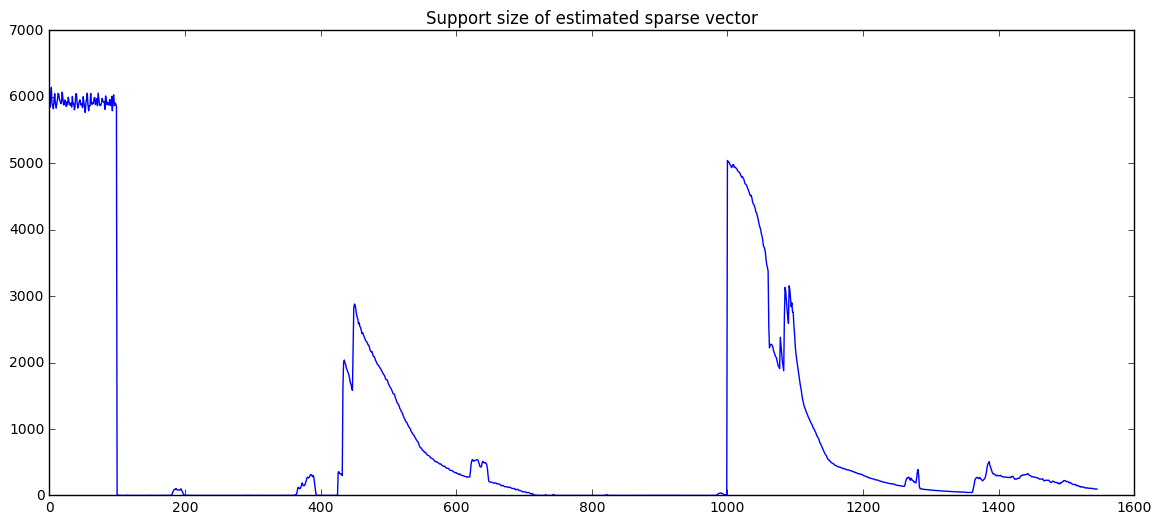

In [47]:
plt.figure(figsize=[14,6])
plt.plot((Shat != 0).sum(axis=0))
plt.title('Support size of estimated sparse vector')

In [48]:
for folder in ['./lobby_jump_OMWRPCA_L/', './lobby_jump_OMWRPCA_S/']:
    try:
        os.stat(folder)
    except:
        os.mkdir(folder)
    filelist = [ f for f in os.listdir(folder)]
    for f in filelist:
        os.remove(folder + f)

In [49]:
writeMatricPng("./lobby_jump_OMWRPCA_L/", "lobby", Lhat.transpose(), 80, 128)

In [50]:
writeMatricPng("./lobby_jump_OMWRPCA_S/", "lobby", Shat.transpose(), 80, 128)

#### OMWRPCA-CP

In [51]:
start = timer()
Lhat, Shat, rank, cp, num_sparses = omwrpca_cp(np.transpose(lobby_mat_jump), burnin=100, win_size=100, track_cp_burnin=100, 
           n_check_cp=3, alpha=0.01, proportion=1, n_positive=3, min_test_size=300, tolerance_num=2000, 
           lambda1=1.0/np.sqrt(200), lambda2=1.0/np.sqrt(200)*(400), factor=1)
end = timer()       
print "Running time of omwrpca-cp: %.3f seconds." % (end - start)
np.save("lobby_mat_low_omwrpca_cp.npy", Lhat.transpose())
np.save("lobby_mat_sparse_omwrpca_cp.npy", Shat.transpose())

Running time of omwrpca-cp: 252.805 seconds.


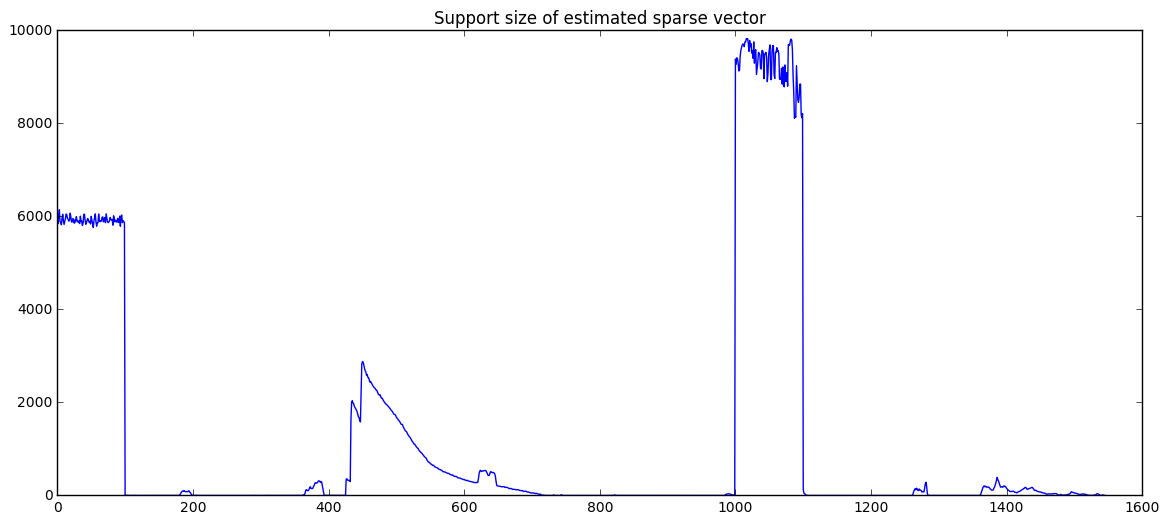

In [52]:
plt.figure(figsize=[14,6])
plt.plot((Shat != 0).sum(axis=0))
plt.title('Support size of estimated sparse vector')

In [53]:
print cp

[1000]


In [54]:
print rank

[1, 44]


In [55]:
for folder in ['./lobby_jump_OMWRPCA_CP_L/', './lobby_jump_OMWRPCA_CP_S/']:
    try:
        os.stat(folder)
    except:
        os.mkdir(folder)
    filelist = [ f for f in os.listdir(folder)]
    for f in filelist:
        os.remove(folder + f)

In [56]:
writeMatricPng("./lobby_jump_OMWRPCA_CP_L/", "lobby", Lhat.transpose(), 80, 128)

In [57]:
writeMatricPng("./lobby_jump_OMWRPCA_CP_S/", "lobby", Shat.transpose(), 80, 128)

### RPCA on lobby video with jumping and moving window

In [78]:
lobby_mat_jump_move = np.load("lobby_mat_jump_move.npy")

In [79]:
print lobby_mat_jump_move.shape

(1546L, 10240L)


#### stoc_rpca

In [98]:
start = timer()
Lhat, Shat, rank, Uhat = stoc_rpca(np.transpose(lobby_mat_jump_move), 100, lambda1=1.0/np.sqrt(200), lambda2=1.0/np.sqrt(200)*(100))
end = timer()       
print "Running time of stoc_rpca: %.3f seconds." % (end - start)
np.save("lobby_mat_low_stoc_rpca.npy", Lhat.transpose())
np.save("lobby_mat_sparse_stoc_rpca.npy", Shat.transpose())

Running time of stoc_rpca: 150.443 seconds.


In [81]:
for folder in ['./lobby_jump_move_STOC_RPCA_L/', './lobby_jump_move_STOC_RPCA_S/']:
    try:
        os.stat(folder)
    except:
        os.mkdir(folder)
    filelist = [ f for f in os.listdir(folder)]
    for f in filelist:
        os.remove(folder + f)

In [82]:
writeMatricPng("./lobby_jump_move_STOC_RPCA_L/", "lobby", Lhat.transpose(), 80, 128)

In [83]:
writeMatricPng("./lobby_jump_move_STOC_RPCA_S/", "lobby", Shat.transpose(), 80, 128)

#### OMWRPCA

In [84]:
start = timer()
Lhat, Shat, rank = omwrpca(np.transpose(lobby_mat_jump_move), burnin=100, win_size=100, lambda1=1.0/np.sqrt(200), lambda2=1.0/np.sqrt(200)*(100))
end = timer()       
print "Running time of omwrpca: %.3f seconds." % (end - start)
np.save("lobby_mat_jump_move_low_omwrpc.npy", Lhat.transpose())
np.save("lobby_mat_jump_move_sparse_omwrpc.npy", Shat.transpose())

Running time of omwrpca: 131.988 seconds.


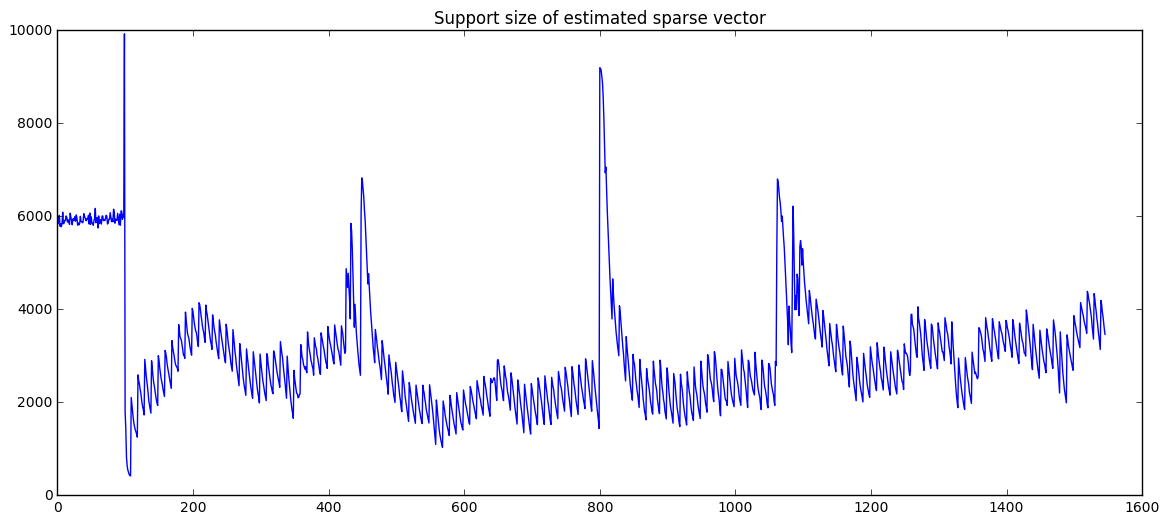

In [85]:
plt.figure(figsize=[14,6])
plt.plot((Shat != 0).sum(axis=0))
plt.title('Support size of estimated sparse vector')

In [86]:
for folder in ['./lobby_jump_move_OMWRPCA_L/', './lobby_jump_move_OMWRPCA_S/']:
    try:
        os.stat(folder)
    except:
        os.mkdir(folder)
    filelist = [ f for f in os.listdir(folder)]
    for f in filelist:
        os.remove(folder + f)

In [87]:
writeMatricPng("./lobby_jump_move_OMWRPCA_L/", "lobby", Lhat.transpose(), 80, 128)

In [88]:
writeMatricPng("./lobby_jump_move_OMWRPCA_S/", "lobby", Shat.transpose(), 80, 128)

#### OMWRPCA-CP

In [89]:
start = timer()
Lhat, Shat, rank, cp, num_sparses = omwrpca_cp(np.transpose(lobby_mat_jump_move), burnin=100, win_size=20, track_cp_burnin=100, 
           n_check_cp=3, alpha=0.01, proportion=1, n_positive=3, min_test_size=300, tolerance_num=1000, 
           lambda1=1.0/np.sqrt(200), lambda2=1.0/np.sqrt(200)*(100), factor=1)
end = timer()       
print "Running time of omwrpca-cp: %.3f seconds." % (end - start)
np.save("lobby_Jmat_low_omwrpca_cp.npy", Lhat.transpose())
np.save("lobby_mat_sparse_omwrpca_cp.npy", Shat.transpose())

Running time of omwrpca-cp: 192.562 seconds.


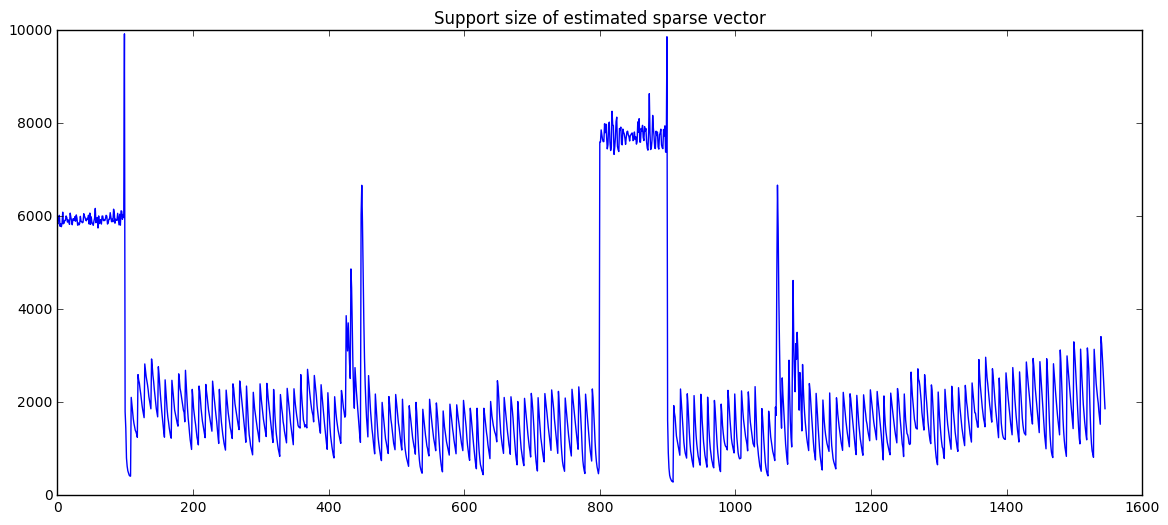

In [90]:
plt.figure(figsize=[14,6])
plt.plot((Shat != 0).sum(axis=0))
plt.title('Support size of estimated sparse vector')

In [91]:
print cp

[800]


In [92]:
print rank

[11, 15]


In [93]:
(Shat != 0).sum(axis=0)[2110:2130]

array([], dtype=int32)

In [94]:
(Shat != 0).sum(axis=0)[2630:2650]

array([], dtype=int32)

In [95]:
for folder in ['./lobby_jump_move_OMWRPCA_CP_L/', './lobby_jump_move_OMWRPCA_CP_S/']:
    try:
        os.stat(folder)
    except:
        os.mkdir(folder)
    filelist = [ f for f in os.listdir(folder)]
    for f in filelist:
        os.remove(folder + f)

In [96]:
writeMatricPng("./lobby_jump_move_OMWRPCA_CP_L/", "lobby", Lhat.transpose(), 80, 128)

In [97]:
writeMatricPng("./lobby_jump_move_OMWRPCA_CP_S/", "lobby", Shat.transpose(), 80, 128)